In [83]:
import numpy as np
from synthesizer.photoionisation import cloudy23
import matplotlib.pyplot as plt
from astropy.io import ascii
from synthesizer.sed import Sed
from unyt import cm, erg, Angstrom, pc, s, h, c


In [84]:

cm_to_parsecs = (1*cm).to('pc').value
parsecs_to_cm = (1*pc).to('cm').value

hydrogen_density = 1E10 / cm**-3
ionisation_parameter = 0.1 

radius_limit = np.array([-7, -3])
column_density_limit = radius_limit + np.log10(parsecs_to_cm) + np.log10(hydrogen_density.to('cm**3').value)

model = 'blr_stopping_column_density' 
stopping_column_densities = [21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 24.5, 25.0, 25.5]



## Ionisation structure

Show all models

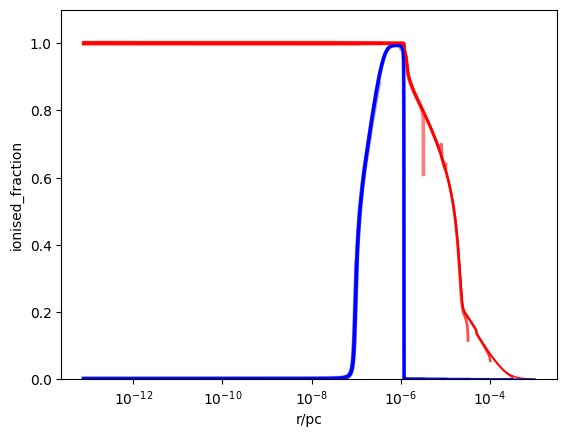

In [85]:
from unyt import cm, pc


fig, ax = plt.subplots()

convert_to_parsecs = (1*cm).to('pc').value

lws = np.linspace(4, 1, len(stopping_column_densities))
alphas = np.linspace(0.1, 1., len(stopping_column_densities))

for i, (v, lw, alpha) in enumerate(zip(stopping_column_densities, lws, alphas)):
    for zone, color in zip(['HII', 'O3'],['r', 'b']):
        data = ascii.read(f'{model}/{i+1}.ovr')
        depth = data['depth'] * cm
        if zone == 'HII':
            label = f'{model}={v}'
        else:
            label = None
        ax.plot(depth.to('pc').value, data[zone], lw=lw, alpha=alpha, c=color, label=label)
        
# ax.legend()
ax.set_xscale('log')
ax.set_xlabel('r/pc')
ax.set_ylabel('ionised_fraction')
# plt.xlim(0, .00005)
ax.set_ylim(0.0, 1.1)
plt.show()

Show final model only

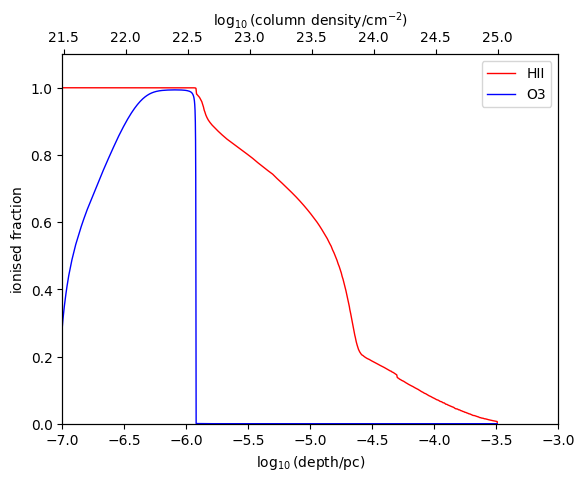

In [86]:

fig, ax = plt.subplots()
ax2 = ax.twiny()

i = len(stopping_column_densities) - 1

for zone, color in zip(['HII', 'O3'],['r', 'b']):
    data = ascii.read(f'{model}/{i}.ovr')
    depth = data['depth'] * cm
    label = f'{zone}'
    ax.plot(np.log10(depth.to('pc').value), data[zone], lw=lw, alpha=alpha, c=color, label=label)
        
ax.legend()

ax.set_xlabel(r'$\rm \log_{10}(depth/pc)$')
ax.set_ylabel(r'$\rm ionised\ fraction$')
ax.set_xlim(radius_limit)
ax.set_ylim(0.0, 1.1)

ax2.set_xlim(column_density_limit)
ax2.set_xlabel(r'$\rm \log_{10}(column\ density/cm^{-2})$')

plt.show()

## Temperature structure

/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_92602/1050175934.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


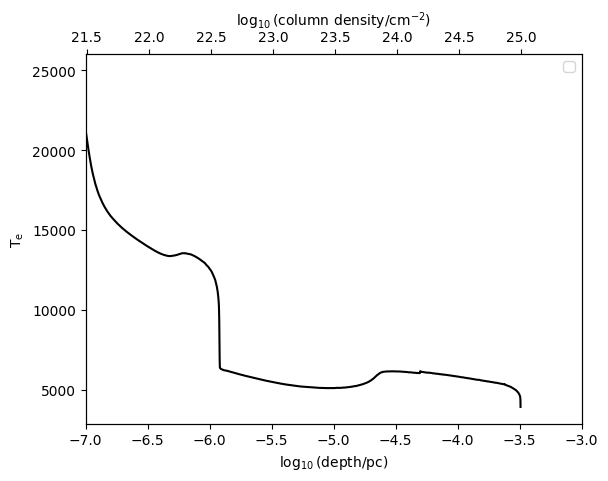

In [93]:
fig, ax = plt.subplots()
ax2 = ax.twiny()

i = len(stopping_column_densities) - 1

data = ascii.read(f'{model}/{i}.ovr')
depth = data['depth'] * cm
label = f'{zone}'
ax.plot(np.log10(depth.to('pc').value), data['Te'], c='k')
        
ax.legend()

ax.set_xlabel(r'$\rm \log_{10}(depth/pc)$')
ax.set_ylabel(r'$\rm T_{e}$')
ax.set_xlim(radius_limit)
# ax.set_ylim(0.0, 1.1)

ax2.set_xlim(column_density_limit)
ax2.set_xlabel(r'$\rm \log_{10}(column\ density/cm^{-2})$')

plt.show()

## H-alpha luminosity / ionising photon luminosity

In [87]:

# get the output spectra - here only for the first model since we only want the incident
lam_, incident = np.loadtxt(f"{model}/1.cont", delimiter="\t", usecols=(0, 1)).T
lam = lam_[::-1] * Angstrom
nu = c / lam
incident_lnu = incident[::-1] * (erg / s) / nu / 1E7
sed = Sed(lam=lam, lnu=incident_lnu)
bolometric_luminosity = sed.bolometric_luminosity
ionising_photon_luminosity = sed.calculate_ionising_photon_production_rate()
print(ionising_photon_luminosity)

2997306538532.056 1/s


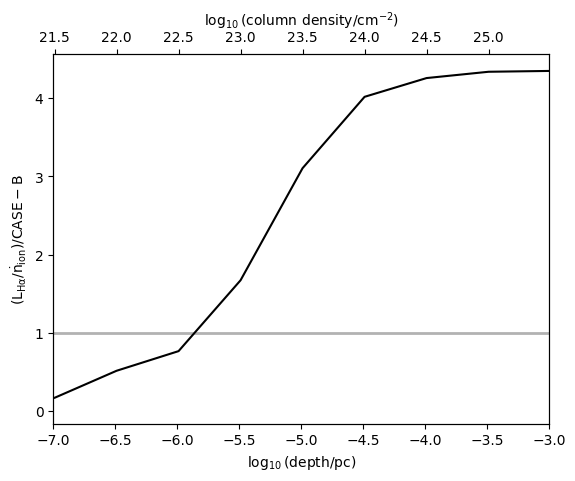

In [94]:

case_b = (1.08E-53 / 7.9E-42) # erg

fig, ax = plt.subplots()
ax2 = ax.twiny()

extension = 'intrinsic_elin'

ratio = []

for i, column_density in enumerate(stopping_column_densities):

    # get tuple of line_id, wavelength, and line luminosity
    linelist = cloudy23.read_linelist(f'{model}/{i+1}', extension=extension)

    # convert tuple of arrays into a dictionary
    line_luminosity = dict(zip(linelist[0], linelist[2]))

    ratio.append(line_luminosity['H 1 6562.80A']/ionising_photon_luminosity.to('1/s').value)




ax2.plot(stopping_column_densities, np.array(ratio)/case_b, c='k')

ax.axhline(1, c='k', lw=2, alpha=0.3)
ax.set_xlabel(r'$\rm \log_{10}(depth/pc)$')
ax.set_ylabel(r'$\rm (L_{H\alpha}/\dot{n}_{ion})/CASE-B$')
ax.set_xlim(radius_limit)
# ax.set_ylim(0.0, 1.1)
ax2.set_xlim(column_density_limit)
ax2.set_xlabel(r'$\rm \log_{10}(column\ density/cm^{-2})$')

plt.show()

## Balmer Decrement

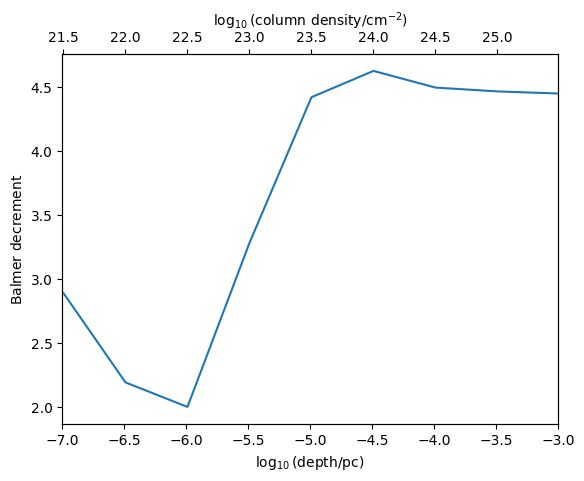

In [89]:

fig, ax = plt.subplots()
ax2 = ax.twiny()

extension = 'intrinsic_elin'

ratio = []

for i, column_density in enumerate(stopping_column_densities):

    # get tuple of line_id, wavelength, and line luminosity
    linelist = cloudy23.read_linelist(f'{model}/{i+1}', extension=extension)

    # convert tuple of arrays into a dictionary
    line_luminosity = dict(zip(linelist[0], linelist[2]))

    # get balmer decrement
    balmer_decrement = line_luminosity['H 1 6562.80A']/line_luminosity['H 1 4861.32A']
    ratio.append(balmer_decrement)

ax2.plot(stopping_column_densities, ratio)

ax.set_xlabel(r'$\rm \log_{10}(depth/pc)$')
ax.set_ylabel(r'$\rm Balmer\ decrement$')
ax.set_xlim(radius_limit)
# ax.set_ylim(0.0, 1.1)
ax2.set_xlim(column_density_limit)
ax2.set_xlabel(r'$\rm \log_{10}(column\ density/cm^{-2})$')

plt.show()


## Plot transmitted specta

In [90]:

# get the input spectra
from unyt import c, h, erg, s, Angstrom

for i, (v, lw, alpha) in enumerate(zip(values, lws, alphas)):

    # get the output spectra
    x, incident, transmitted, nebular, total, linecont = np.loadtxt(f"{model}/{i+1}.cont", delimiter="\t", usecols=(0, 1, 2, 3, 4, 8)).T

    lam = x[::-1] * Angstrom
    nu = c / lam

    # plot incident
    if  i==0:
        incident_ = incident[::-1] * (erg / s) 
        plt.loglog(lam.to('Angstrom').value, incident_, label='incident', lw=3, c='k', alpha=0.2)

        incident_sed = Sed(lam=lam, lnu=incident_/nu)
        print('incident', incident_sed.bolometric_luminosity)

    label = f'{model}={v}'
    spectra = total[::-1] * (erg / s)
    # plt.loglog(lam.to('Angstrom').value, transmitted, label=label, lw=lw, alpha=alpha, c='r')
    # plt.loglog(lam.to('Angstrom').value, spectra, label=label)

    nebular_continuum = (nebular - linecont) * (erg / s) 


    plt.loglog(lam.to('Angstrom').value, nebular_continuum, label=label)

    sed = Sed(lam=lam, lnu=spectra/nu)
    print(f"{v} {sed.bolometric_luminosity:.2f} {sed.bolometric_luminosity/incident_sed.bolometric_luminosity:.2f} ")


plt.xlim([4000,7000])
plt.ylim(1E7, 1E9)
plt.legend()
plt.show()





NameError: name 'values' is not defined

## Plot Ha/L_bol

In [ ]:

incident_lnu = incident[::-1] * (erg / s) / nu / 1E7
sed = Sed(lam=lam, lnu=incident_lnu)
bolometric_luminosity = sed.bolometric_luminosity
Q = sed.calculate_ionising_photon_production_rate()
print(Q)

# Case B correction factor
correction_factor = (1.08E-53 / 7.9E-42) * erg

extension = 'intrinsic_elin'

lines = ['H 1 6562.80A', 'H 1 4861.32A']

luminosity = {line : [] for line in lines}

bolometric_ratio = []
Q_ratio = []

for i, value in enumerate(values):

    # get tuple of line_id, wavelength, and line luminosity
    linelist = cloudy23.read_linelist(f'{model}/{i+1}', extension=extension)

    # convert tuple of arrays into a dictionary
    line_luminosity = dict(zip(linelist[0], linelist[2] * erg/s))

    bolometric_ratio.append(line_luminosity['H 1 6562.80A']/bolometric_luminosity)


    Q_rat = line_luminosity['H 1 6562.80A']/Q
    print(Q_rat)
    Q_ratio.append(Q_rat)


plt.axhline(1/130.)   
plt.plot(values, bolometric_ratio)   
plt.ylabel('$L_{Ha}/L_{bol}$')
plt.xlabel(model)

plt.show()

plt.plot(values, np.log10(np.array(Q_ratio)))
plt.axhline(np.log10(correction_factor.to('erg').value))   
plt.ylabel('$L_Ha/Q$')
plt.xlabel(model)
plt.show()